<a href="https://colab.research.google.com/github/Noam-and-Iftach/DS20936/blob/2.5/done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Here we begin by taking the jsons we downloaded and spliting them into parquets so it will be easy to work with*

We split all 4 files: meta_Books.json, Books.json, meta_Kindle_Store.json, Kindle_store.json into chunks:


In [ ]:
import pandas as pd
#!pip install polars
#!pip install pyarrow
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 23.0 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:

# Input and output file paths
json_file_path = '/content/drive/MyDrive/Books2.json'
parquet_output_dir = '/content/drive/MyDrive/books-parquet/'

# Chunk size
chunk_size = 50000

# Read JSON data in chunks
json_reader = pd.read_json(json_file_path, lines=True, chunksize=chunk_size)

# Create an Arrow table from each chunk and write to Parquet
for i, chunk in enumerate(json_reader):

    # Convert the DataFrame chunk to an Arrow table
    table = pa.Table.from_pandas(chunk)

    # Create an incremental Parquet file name
    parquet_file_name = f'output_chunk_{i + 1}.parquet'

    # Construct the full path to the Parquet file
    parquet_file_path = f'{parquet_output_dir}{parquet_file_name}'

    # Write the Arrow table to Parquet
    pq.write_table(table, parquet_file_path)


print(f"Data has been successfully converted to Parquet: {parquet_file_path}")

KeyboardInterrupt: 

for the meta files we first coverted them into csv, and then to parquets

In [ ]:
import pandas as pd
import csv  # Import for CSV handling
from google.colab import drive


json_file_path = '/content/drive/MyDrive/meta_Books.json'
csv_output_path = '/content/drive/MyDrive/meta-books-csv/'

# Read the JSON file in chunks with error handling and potential escape fixes
chunksize = 20000
chunk_counter = 1

try:
    for chunk in pd.read_json(json_file_path, lines=True, chunksize=chunksize):
        if chunk_counter%200==0:
          print("Current chunk is:", chunk_counter)

        # Process the chunk
        processed_chunk = chunk

        # Create a unique filename for each chunk
        output_filename = f'meta-books-csv-chunk_{chunk_counter}.csv'
        output_filepath = f'{csv_output_path}{output_filename}'

        try:
            processed_chunk.to_csv(output_filepath, index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
            chunk_counter += 1
        except pd.errors.ParserError as e:
            print(f"Error processing chunk {chunk_counter}: {e}")


except pd.errors.ParserError as e:
    print("Error decoding JSON:", e)


print("Processing complete! CSV files saved to:", csv_output_path)


In [ ]:
import os
from pathlib import Path

# Set the path to your CSV files
csv_directory = '/content/drive/MyDrive/meta-books-csv/'

# Set the path where you want to save the Parquet files
parquet_directory = '/content/drive/MyDrive/meta-books-parquet/'

# Create the output directory if it doesn't exist
Path(parquet_directory).mkdir(parents=True, exist_ok=True)

# List all CSV files in the directory
csv_files = [file for file in os.listdir(csv_directory) if file.startswith('meta-books-csv') and file.endswith('.csv')]
counter=0
# Loop through each CSV file and convert it to Parquet
for csv_file in csv_files:
    counter+=1

    # Load CSV file into a DataFrame
    df = pd.read_csv(os.path.join(csv_directory, csv_file))

    # Define the path for the output Parquet file
    parquet_file = os.path.join(parquet_directory, csv_file.replace('.csv', '.parquet'))

    # Convert DataFrame to Parquet and save it
    df.to_parquet(parquet_file, engine='pyarrow')

print("Conversion completed.")

*THE BEGINNING OF ACTUALLY WORKING WITH THE DATA*

We created a file called "Both" that contains 'reviewerID' for each of the 2 files. then we created queries to see how many IDs have more than 10 in both of the sources. This was done in the beginning just to get a first feeling of the data.

TODO - we need to read all files later




In [ ]:

# Create an empty Polars DataFrame with schema
all_reviewer_ids = pl.DataFrame(schema={'reviewerID': pl.Utf8})  # Use Utf8 for strings

# Path to the Parquet files
path_to_parquet_files = '/content/drive/MyDrive/books-parquet/'

# Accumulate reviewer IDs
for i in range(1, 1027):
    # Construct file path
    file_path = path_to_parquet_files + f"output_chunk_{i+1}.parquet"

    # Read the Parquet file using Polars
    df = pl.read_parquet(file_path, columns=["reviewerID"])

    # Concatenate the DataFrame
    all_reviewer_ids = pl.concat([all_reviewer_ids, df])



#Loop through each file and append the reviewerID to the Series
'''for i in range(15):
    index = 1027 - i
    file_path = path_to_parquet_files + f"output_chunk_{index}.parquet"
    df = pd.read_parquet(file_path)
    print(index)
    all_reviewer_ids = all_reviewer_ids.append(df['reviewerID'], ignore_index=True)'''



In [ ]:
reviewer_ids = pd.DataFrame(all_reviewer_ids)
reviewer_ids.columns = ['reviewerID']
reviewer_ids['source']='books'
#reviewer_ids.to_csv('books_reviewerID.csv', index=False)


In [ ]:


# Group by reviewerID and count the occurrences
reviewer_id_counts = all_reviewer_ids.value_counts().reset_index()
reviewer_id_counts.columns = ['reviewerID', 'count']

#reviewer_id_counts.to_csv('books_reviewerID_count.csv', index=False)


# The DataFrame reviewer_id_counts now holds the reviewerID and its count
print(reviewer_ids.head())

we added "source" for the files, to know the source of each record. Then we used ploty.express to visualize the amount of reviewers which has reviews in both of the files

In [ ]:
# Read the CSV file
csv_file_path = '/content/drive/MyDrive/kindle_reviewerID.parquet'
books_df = pd.read_parquet(csv_file_path)
books_df['source']='books'
# Read the Parquet file
parquet_file_path = '/content/drive/MyDrive/kindle_reviewerID.parquet'
kindle_df = pd.read_parquet(parquet_file_path)

# Add a 'source' column to the kindle_df DataFrame
kindle_df['source'] = 'kindle'

# Concatenate the two DataFrames
combined_df = pd.concat([books_df, kindle_df], ignore_index=True)

# Save the concatenated DataFrame to a new file
#output_file_path = 'reviewerID_both.csv'
#combined_df.to_csv(output_file_path, index=False)

#print(f"Data saved to {output_file_path}")


In [ ]:
combined_df

,reviewerID,source
0,A27UD5HYAKBL97,books
1,A8P5DK8LLOYGH,books
2,A3OM9W7DXSUIIY,books
3,A3DPAR2PWB9BT8,books
4,A2ONTBSAX7GIOV,books
...,...,...
11445971,A3564F5AHYGXIK,kindle
11445972,A1UX5HUK0QI049,kindle
11445973,A2IHCZ2QVATVMZ,kindle
11445974,A2FNGRZF97UZ49,kindle


In [ ]:


# Group by reviewerID and count the occurrences of each source
reviewer_source_counts = combined_df.groupby('reviewerID')['source'].value_counts().unstack(fill_value=0)

# Reset the index to turn reviewerID into a column
reviewer_source_counts.reset_index(inplace=True)

#Renaming columns
reviewer_source_counts.columns = ['reviewerID', 'count_books', 'count_kindle']

print(reviewer_source_counts.head())

#Saving to csv
#reviewer_source_counts.to_csv('grouped_reviewerID_count.csv', index=False)

             reviewerID  count_books  count_kindle
0  A00006301SOXP1JTSSEW            1             1
1  A000392684P4JNLQRBBW            1             1
2  A0004870ERG4H2S4AOVF            2             2
3  A0010876CNE3ILIM9HV0            4             4
4  A00120388GYIVNULTK82            1             1


In [ ]:
import plotly.express as px

fig = px.scatter(reviewer_source_counts, x='count_books', y='count_kindle',
                 title='Comparison of Book and Kindle Reviews per Reviewer',
                 labels={'count_books': 'Count of Books Reviews', 'count_kindle': 'Count of Kindle Reviews'})
fig.show()


In [ ]:
import plotly.express as px

# Filter the DataFrame to include only rows where both counts are greater than 10
filtered_df = reviewer_source_counts[(reviewer_source_counts['count_books'] > 10) &
                                     (reviewer_source_counts['count_kindle'] > 10)]

fig = px.scatter(filtered_df, x='count_books', y='count_kindle',
                 title='Comparison of Book and Kindle Reviews per Reviewer (Counts > 10)',
                 labels={'count_books': 'Count of Books Reviews', 'count_kindle': 'Count of Kindle Reviews'})
fig.show()


We saw that there are enough reviewers which has reviews in both of the files, so we wanted to take a sample of 10 records from each file, of 5 reviewers. We wanted to check for duplications of reviewers between two datasets

In [ ]:
filtered_df_10 = reviewer_source_counts[(reviewer_source_counts['count_books']  == 10) &
                                     (reviewer_source_counts['count_kindle'] == 10)]

In [ ]:
import pandas as pd
import os
#TODO NOT CLEAR WHAT IS SAMPLE

reviewer_ids_sample = sampled_records['reviewerID'].tolist()

# Initialize a list to hold DataFrames
filtered_dataframes = []

# Process books_{index}.parquet files
for i in range(1, 16):

    file_path = path_to_parquet_files +  f'output_chunk_{i}.parquet'
    if os.path.exists(file_path):
        df = pd.read_parquet(file_path)
        filtered_df = df[df['reviewerID'].isin(reviewer_ids_sample)]
        filtered_dataframes.append(filtered_df)

for i in range(15):
    index = 1027-i
    file_path = path_to_parquet_files +  f'output_chunk_{index}.parquet'
    if os.path.exists(file_path):
        df = pd.read_parquet(file_path)
        filtered_df = df[df['reviewerID'].isin(reviewer_ids_sample)]
        filtered_dataframes.append(filtered_df)

# Process kindle parquet files
base_kindle = "/content/drive/MyDrive/kindle-parquet/"
for i in range(1, 287):

    file_path = base_kindle + f'kindle-csv-chunk_{i}.parquet'
    if os.path.exists(file_path):
        df = pd.read_parquet(file_path)
        filtered_df = df[df['reviewerID'].isin(reviewer_ids_sample)]
        filtered_dataframes.append(filtered_df)

# Concatenate all filtered DataFrames
combined_filtered_df = pd.concat(filtered_dataframes, ignore_index=True)
combined_filtered_df.to_csv('check_for_different_kindle_books_reviews.csv', index=False)
# Now `combined_filtered_df` contains all records from all the parquet files
# that have a reviewerID present in your sampled records


NameError: name 'sampled_records' is not defined

We saw that in the sample of information, there is Kindle inside Books.json and vice versa.


We saw that this two formats: kindle, and hardcover, are not the only formats within those datasets. So we wanted to see how many formats are there

In [ ]:

df=pq.read_table('/content/drive/MyDrive/books_only_style_column.parquet')
df=df.to_pandas()
filtered_counts =df['style'].value_counts()
df

,Unnamed: 0,style
0,0,{'Format:': ' Paperback'}
1,1,{'Format:': ' Hardcover'}
2,2,{'Format:': ' Hardcover'}
3,3,{'Format:': ' Hardcover'}
4,4,None
...,...,...
8557289,8557289,"{'Color:': None, 'Format:': ' Paperback', 'Siz..."
8557290,8557290,"{'Color:': None, 'Format:': ' Kindle Edition',..."
8557291,8557291,"{'Color:': None, 'Format:': ' Kindle Edition',..."
8557292,8557292,"{'Color:': None, 'Format:': ' Kindle Edition',..."


We saw that there are many "style" fields that have None values, now we check for statistics of the style:

In [ ]:
filtered_counts=filtered_counts[filtered_counts > 100]
print(filtered_counts)

style
{'Format:': ' Kindle Edition'}            17172000
{'Format:': ' Paperback'}                  8129082
{'Format:': ' Hardcover'}                  5152115
{'Format:': ' Mass Market Paperback'}      1023654
{'Format:': ' Board book'}                  206655
                                            ...   
{'Format:': ' HD DVD'}                         120
{'Color:': None, 'Format:': ' MP3 CD'}         117
{'Format:': ' DVD-ROM', 'Size:': None}         116
{'Format:': ' Software'}                       115
{'Format:': ' Baby Product'}                   112
Name: count, Length: 143, dtype: int64


# TODO: use value counts and remove comments and

In [ ]:
import os
base_file_name = 'kindle-csv-chunk_{}.parquet'
file_location = '/content/drive/MyDrive/kindle-parquet/'

concatenated_df=pl.DataFrame(schema={'reviewerID': pl.Utf8})

start_file_number = 1
end_file_number = 287


# Loop through each file number and append its data to the concatenated DataFrame
file_paths = [os.path.join(file_location, base_file_name.format(i)) for i in range(start_file_number, end_file_number + 1)]
concatenated_df = pl.read_parquet(file_paths, columns=["style"])



In [ ]:
concatenated_df_for_value_counts=concatenated_df.drop_nulls()
concatenated_df_for_value_counts['style'].value_counts(sort=True)


 We took only the first four which are:  Kindle Edition, paperback, Hardcover, Mass Market Paperback. This is becuase we are not looking for DVDs, Software, and Baby Products

{'Format:': ' Kindle Edition'}                     5045160
{'Format:': ' Paperback'}                           165154
{'Format:': ' Hardcover'}                            72067
{'Format:': ' Mass Market Paperback'}                10295
{'Format:': ' Audible Audiobook'}                     6455
{'Format:': ' Audio CD'}                              2602
{'Format:': ' Board book'}                            1827
{'Format:': ' Kindle Edition with Audio/Video'}       1429
{'Format:': ' Print Magazine'}                        1116
{'Format:': ' Perfect Paperback'}                      533
{'Format:': ' Leather Bound'}                          463
{'Format:': ' MP3 CD'}                                 419
{'Format:': ' Flexibound'}                             341
{'Format:': ' Comic'}                                  291
{'Format:': ' DVD'}                                    276
{'Format:': ' Spiral-bound'}                           154
{'Format:': ' Library Binding'}                        1

In [ ]:

base_file_name = 'kindle-csv-chunk_{}.parquet'
file_location = '/content/drive/MyDrive/kindle-parquet/'


start_file_number = 1
end_file_number = 287

# Initialize an empty DataFrame to store the concatenated data
concatenated_df = pd.DataFrame()

# Loop through each file number and append its data to the concatenated DataFrame
for file_number in range(start_file_number, end_file_number + 1):

    file_path = file_location + base_file_name.format(file_number)
    table = pq.read_table(file_path)
    df = table.to_pandas()
    concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)


Let's check the validation of the review time:

In [ ]:
counting_reviewer_per_time_sorted = concatenated_df.groupby(["reviewerID", "unixReviewTime"]).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
counting_reviewer_per_time_sorted.head()

,reviewerID,unixReviewTime,counts
4903806,AWHX7AT8548LB,1453593600,163
4683173,AQBTNZ9ZD08PD,1499990400,134
3781289,A3TY31K1VXAGSX,1443139200,132
2377560,A2S16KJUW9MAOR,1412380800,106
1487995,A23SB7XAREYGF2,1468800000,99


This is intresting, why we have so many reviews for the same user in the exact same time? Let's examine one user

In [ ]:
reviewer_with_99_same_time = concatenated_df.loc[(concatenated_df["reviewerID"] == "A23SB7XAREYGF2") &
                                                 (concatenated_df["unixReviewTime"] == 1468800000)]
reviewer_with_99_same_time.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
184221,5,False,"07 18, 2016",A23SB7XAREYGF2,B0050YYMHI,{'Format:': ' Kindle Edition'},Dessie Harlow,Great author. I enjoyed the book.,Great author. I enjoyed the book,1468800000,NaN,None
683174,5,True,"07 18, 2016",A23SB7XAREYGF2,B00A9FYVXS,{'Format:': ' Kindle Edition'},Dessie Harlow,Awesome author and series!,Five Stars,1468800000,NaN,None
730022,5,True,"07 18, 2016",A23SB7XAREYGF2,B00ALG6UW0,{'Format:': ' Kindle Edition'},Dessie Harlow,Awesome series and author!,Five Stars,1468800000,NaN,None
790373,5,True,"07 18, 2016",A23SB7XAREYGF2,B00B1QCPNM,{'Format:': ' Kindle Edition'},Dessie Harlow,Awesome series and author!! I enjoyed the series!,Five Stars,1468800000,NaN,None
839056,5,True,"07 18, 2016",A23SB7XAREYGF2,B00BG1ZLL0,{'Format:': ' Kindle Edition'},Dessie Harlow,Awesome series and author!!!,Five Stars,1468800000,NaN,None


In [ ]:
reviewer_with_99_same_time.describe()

,overall,unixReviewTime
count,99.0,9.900000e+01
mean,5.0,1.468800e+09
std,0.0,0.000000e+00
min,5.0,1.468800e+09
25%,5.0,1.468800e+09
50%,5.0,1.468800e+09
75%,5.0,1.468800e+09
max,5.0,1.468800e+09


We saw that he gave "5" stars rating all the reviews in that time, is it a bot that rates everything "5"? What are his other reviews' rating?

In [ ]:
reviewer_with_99_reviews = concatenated_df.loc[(concatenated_df["reviewerID"] == "A23SB7XAREYGF2")]
reviewer_with_99_reviews.overall.describe()

count    121.0
mean       5.0
std        0.0
min        5.0
25%        5.0
50%        5.0
75%        5.0
max        5.0
Name: overall, dtype: float64

We saw that all of it's reviews has overall of 5, however, if we look at the asin of the books, we can see that they are reviews on different books!

In [ ]:
reviewer_with_99_reviews.asin.describe()

count            121
unique           121
top       B01HHEF6OQ
freq               1
Name: asin, dtype: object

First, we see that this are different books.
One thing very nice about our data, that we can browse the web and actually see the reviews. We can see that in the same time, the same reviewer, has the exact same text review: "Enjoyed the book" on different reviews, however, the reviews are verified on amazon, and you can see *Dessie Harlow*'s reviews here:
https://www.amazon.ca/Only-One-Dream-Circle-Friends-ebook/dp/B01HHEF6OQ
https://www.amazon.com/CHOCOLATE-COWBOY-SLEEP-DREAMING-Book-ebook/dp/B01EZ9IJHC
https://www.amazon.in/product-reviews/B078XNZYWY/ref=dbs_a_def_rwt_hsch_vwpw_tkin_p1_i3

So we assume that whether amazon has imported reviews on the same time, or verified on the same time, anyway, the reviews are legitimates.

Let's understand the amount of reviews within the kindle.json that are kindle format only:


# TODO: run this

EXPLAIN WHY WE RAN THIS--perhaps we wanted to focus only on kindle inside kindle to get some idea of the data

In [ ]:
# Filter by 'style'

filtered_df = concatenated_df[concatenated_df['style'] == "{'Format:': ' Kindle Edition'}"]

# Drop the unnecessary columns
filtered_df = filtered_df.drop(columns=['reviewTime', 'unixReviewTime', 'image'])

# Group by 'reviewerID' and count the reviews
review_counts = filtered_df.groupby('reviewerID').size()

# Filter to get reviewers with at least 10 reviews
reviewers_with_10_plus = review_counts[review_counts >= 10].index

# Get records of these reviewers from the filtered DataFrame
result_df = filtered_df[filtered_df['reviewerID'].isin(reviewers_with_10_plus)]

# Now result_df contains the filtered records
print(result_df.shape)

(1898297, 9)


In [ ]:
#checking how many have at least ten reviews
reviewers_with_more_than_10 = review_counts[review_counts >= 10]

print(reviewers_with_more_than_10.sort_values(ascending=False))

reviewerID
A328S9RN3U5M68    1741
A13QTZ8CIMHHG4    1423
A1JLU5H1CCENWX    1380
A2W4Z0J9DFZFSR    1101
A3GWE80SUGORJD    1006
                  ... 
A2O58LFIA26DT2      10
AK86UYM6FR6Z2       10
A188JQ3IDHKIO7      10
A188NCX32WQNU7      10
A1893KK0B54RKT      10
Length: 63430, dtype: int64


In [ ]:
import plotly.express as px

# Create a histogram / bin graph of the review counts with a bin width of 50 using Plotly Express
fig = px.histogram(reviewers_with_more_than_10, x=reviewers_with_more_than_10.values,
                   nbins=int(reviewers_with_more_than_10.max() / 25),
                   labels={'x': 'Review Counts', 'y': 'Number of Reviewers'},
                   title='Distribution of Review Counts per Reviewer')

# Update layout for clarity
fig.update_layout(bargap=0.2)
fig.show()



Since we reach to the limitations of the RAM memory, Let's now divide all the data within "books.json" into files containing only "kindle" format or one of the three formats "Hardcover", "Paperback", "Mass Market Paperback" as "books".

While running on the data we will start removing non-important colomns: 'reviewTime', 'unixReviewTime', 'image'.
We saw that the time fields are not reliable, in addition, we don't see any value of images that users had uploaded, like we can see here from one of the values of "image" in a user review:
https://images-na.ssl-images-amazon.com/images/I/41-rKHdQczL._SY88.jpg


# TODO: use for loops and minimun lines of code without showing the output that shows we created 14 files-NO NEED TO RUN ACTUALLY< IT IS JUST PRE PROCESSING

In [ ]:
NEEDS TO BE FIXED> I CHANGED IT AS RAM GREW
#reading entire book dataset, filtering out only the kindle style, then concat to kindle dataset, while alo keping only the 3 top styles other than kindle
#1st part
# Specify the base file name and its location
base_file_name = 'output_chunk_{}.parquet'
file_location = '/content/drive/MyDrive/books-parquet/'  # Update this with the actual path

# Specify the range of file numbers you want to include
start_file_number = 1
end_file_number = 1027  # Adjust this based on your actual file range

# Initialize an empty DataFrame to store the concatenated data
df_kindle_concatenated = pd.DataFrame()
df_books_concatenated = pd.DataFrame()

# Loop through each file number and append its data to the concatenated DataFrame
for file_number in range(start_file_number, end_file_number + 1):
    if file_number%50==0:
      print(file_number)
    file_path = file_location + base_file_name.format(file_number)
    df = pq.read_table(file_path)
    df=df.to_pandas()
    df=df.drop(columns=['reviewTime', 'unixReviewTime', 'image'])
    df['vote'] = df['vote'].astype(str)
    df["asin"] = df["asin"].astype(str)

    df_kindle = (df[df['style'].astype(str) == "{'Format:': ' Kindle Edition'}"])
    df_books = df[df['style'].astype(str).isin(["{'Format:': ' Paperback'}", "{'Format:': ' Hardcover'}", "{'Format:': ' Mass Market Paperback'}"])]

    df_kindle_concatenated = pd.concat([df_kindle_concatenated, df_kindle], ignore_index=True)
    df_books_concatenated = pd.concat([df_books_concatenated, df_books], ignore_index=True)

df_kindle_concatenated['asin'] = df_kindle_concatenated['asin'].astype(str)
df_books_concatenated['asin'] = df_books_concatenated['asin'].astype(str)

df_kindle_concatenated.to_parquet("/content/drive/MyDrive/books_to_kindle_and_books_parquets/kindle/kindle_7.parquet")
df_books_concatenated.to_parquet("/content/drive/MyDrive/books_to_kindle_and_books_parquets/books/books_7.parquet")


When exaiming the data from kindle.json we can see that:
1. the amount of data within kindle is way less then the data within books, and for each category, the books.json has more reviews.
2. We can't load both files and check for duplicates between those two large files, due to the amount of the data
3. We saw that in the webpage of the data, it is written that the data wasn't given officialy by amazon, and was web scraped from amazon pages (which also explains the "Baby product" and other formats within the "style" field), and the researchers claim that there might be duplications.

We decided to continue *only* with the **books.json**, and split it into kindle and the other 3 books categories we mentioned earlier.

We split the books.json into 14 files, seperated into kindle format and 3 other books formats, now we will use the first book parquet file only, and build the model with it, and later on we will test it on other parts, Let's start more statistics about the first_book.

# TODO: move this down, and decide what should be function, what should be removed

# from here we need to run it for all the 14 files

# ** problem, books_1_parquet doesnt answer to the regular scheme-iftach will explaon**


In [ ]:
df=pl.read_parquet("/content/drive/MyDrive/books_to_kindle_and_books_parquets/books/books_1.parquet")
for i in range(2,8):
  file_path=f"/content/drive/MyDrive/books_to_kindle_and_books_parquets/books/books_{i}.parquet"
  df_books=pl.read_parquet(file_path)
  df=df.vstack(df_books)



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988 entries, 0 to 2987
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         2988 non-null   int64  
 1   verified        2988 non-null   bool   
 2   reviewTime      2988 non-null   object 
 3   reviewerID      2988 non-null   object 
 4   asin            2988 non-null   object 
 5   style           2737 non-null   object 
 6   reviewerName    2988 non-null   object 
 7   reviewText      2988 non-null   object 
 8   summary         2983 non-null   object 
 9   unixReviewTime  2988 non-null   int64  
 10  vote            202 non-null    float64
 11  image           11 non-null     object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 259.8+ KB


In [ ]:
df.describe().round(2)


,overall,text_length
count,20839638.00,20839638.00
mean,4.39,101.88
std,1.09,158.71
min,0.00,0.00
25%,4.00,19.00
50%,5.00,47.00
75%,5.00,120.00
max,5.00,6888.00


In [ ]:
column_details = [(column, df[column].nunique(), df[column].dtype) for column in df.columns if column != "style"]
column_summary_df = pd.DataFrame(column_details, columns=['feature name', 'unique', 'type'])
print(column_summary_df)

       feature name    unique      type
0           overall         6     int64
1          verified         2      bool
2        reviewerID   8477918    object
3              asin   1470061    object
4      reviewerName   4955430    object
5        reviewText  19002763    object
6           summary  11883692    object
7              vote      2286    object
8       text_length      4387     int64
9  text_length_bins         7  category



Let's start correcting NaN values:

In [ ]:
df.apply(lambda col: col.isin(["nan", "NaN", "None"]).sum())


overall                    0
verified                   0
reviewerID                 0
asin                       0
style                      0
reviewerName             739
reviewText               578
summary                  134
vote                14470275
text_length                0
text_length_bins           0
dtype: int64

We can see that out of 3.4 million reviews, most of the vote values are NaN, and we barely have NaN values in the colomns: summary, reviewText. We decided to discarded the vote since it doesn't provide additional information, and also reviewerName, since the system will recommand based on the reviwerID

In [ ]:
import numpy as np
# Create a copy of the original DataFrame
first_book_after_preprocessing = df.copy()
first_book_after_preprocessing.drop(columns=["vote", "reviewerName"], inplace=True)

# Convert "nan", "NaN", "None", and empty strings to np.nan in the new DataFrame
first_book_after_preprocessing.replace(["nan", "NaN", "None", ""], np.nan, inplace=True)

# Drop rows with any np.nan values in the new DataFrame
first_book_after_preprocessing.dropna(inplace=True)

Due to different variable type, we would fix the colomn to avoid bugs:

In [ ]:
first_book_after_preprocessing["style"] = first_book_after_preprocessing["style"].astype(str)

In [ ]:
first_book_after_preprocessing.shape

(20836474, 9)

In [ ]:
print(first_book_after_preprocessing.duplicated().sum())


22827


Let's view some duplicate data:

In [ ]:
# Identify all duplicate rows, including their first occurrence
duplicates = first_book_after_preprocessing.duplicated(keep=False)

# Filter the DataFrame to view only the duplicate rows
duplicate_rows = first_book_after_preprocessing[duplicates]

duplicate_rows.head()

,overall,verified,reviewerID,asin,style,reviewText,summary,text_length,text_length_bins
1007,5,False,AN4RKQM9AYVAD,0001384198,{'Format:': ' Hardcover'},I liked this book because it motivated me to d...,This book is good for anyone who have kids.,44,1-50
1008,5,False,AN4RKQM9AYVAD,0001384198,{'Format:': ' Hardcover'},I liked this book because it motivated me to d...,This book is good for anyone who have kids.,44,1-50
1170,5,True,A3IVT3UA3ZERWQ,0001381733,{'Format:': ' Hardcover'},Excellent!!,Excellent!!,1,1-50
1171,5,True,A3IVT3UA3ZERWQ,0001381733,{'Format:': ' Hardcover'},Excellent!!,Excellent!!,1,1-50
1195,5,True,A3PYRSATCV6329,0001381733,{'Format:': ' Hardcover'},A gift,Five Stars,2,1-50


We still has huge amount of data, and negligible amount of duplicates, let's remove them:

In [ ]:
first_book_after_preprocessing.drop_duplicates(keep=False, inplace=True)


Let's see if we have users which reviewed the same book more than once:

In [ ]:
reviews_count = first_book_after_preprocessing.groupby(['reviewerID', 'asin']).size().reset_index(name='number_of_reviews').sort_values(by='number_of_reviews', ascending=False)
reviews_count.head()

,reviewerID,asin,number_of_reviews
10046071,A2TXR85WQLE32N,0140324623,57
1977914,A1D2C0WDCSHUWZ,B001C4VLZQ,36
1975973,A1D2C0WDCSHUWZ,000711835X,35
13731815,A3I8FT707XKQAJ,1421520613,25
1977208,A1D2C0WDCSHUWZ,0553212737,20


This means there are many reviews for the same book by the same reviewer. How many reviews like this are there?

In [ ]:
(reviews_count[reviews_count["number_of_reviews"] > 1])["number_of_reviews"].sum()

110336

Let's view the user with the most amount of reviews for the same book:

In [ ]:
filtered_df = first_book_after_preprocessing[(first_book_after_preprocessing['reviewerID'] == 'A1D2C0WDCSHUWZ') & (first_book_after_preprocessing['asin'] == '0007350783')]
filtered_df.head(74)

,overall,verified,reviewerID,asin,style,reviewText,summary,text_length,text_length_bins
194890,4,False,A1D2C0WDCSHUWZ,0007350783,{'Format:': ' Hardcover'},"""Emma Woodhouse, handsome, clever, and rich, w...",It's such a happiness when good people get tog...,573,512+
195068,4,False,A1D2C0WDCSHUWZ,0007350783,{'Format:': ' Paperback'},"""Emma Woodhouse, handsome, clever, and rich, w...",It's such a happiness when good people get tog...,573,512+
196692,5,False,A1D2C0WDCSHUWZ,0007350783,{'Format:': ' Paperback'},Gothic romances were all the rage in the late ...,When a young lady is to be a heroine,578,512+
196718,5,False,A1D2C0WDCSHUWZ,0007350783,{'Format:': ' Paperback'},"In Jane Austen's time, young women were taught...",A second,550,512+
196939,5,False,A1D2C0WDCSHUWZ,0007350783,{'Format:': ' Hardcover'},Gothic romances were all the rage in the late ...,When a young lady is to be a heroine,578,512+
196940,5,False,A1D2C0WDCSHUWZ,0007350783,{'Format:': ' Paperback'},"One of the Dashwood daughters is smart, down-t...",The sensitive and the sensible,552,512+
199395,4,False,A1D2C0WDCSHUWZ,0007350783,{'Format:': ' Paperback'},"""Emma Woodhouse, handsome, clever, and rich, w...",It's such a happiness,572,512+
199837,5,False,A1D2C0WDCSHUWZ,0007350783,{'Format:': ' Paperback'},"""Emma Woodhouse, handsome, clever, and rich, w...",It's such a happiness...,572,512+
200148,4,False,A1D2C0WDCSHUWZ,0007350783,{'Format:': ' Hardcover'},Even the best authors in the world sometimes p...,Everybody likes to go their own way,495,401-512
200182,5,False,A1D2C0WDCSHUWZ,0007350783,{'Format:': ' Mass Market Paperback'},"""Emma Woodhouse, handsome, clever, and rich, w...",It's such a happiness...,573,512+


Once again, we can search amazon for the reviews of this user  (*	E. A. Solinas*) to understand the data. We found this:


This means that all the reviews we saw earlier, are reviews that the user did write, however, as we can see, the review was either on the same book Emma, that was in different version in amazon
https://www.amazon.com/Emma-Be-Classics-Jane-Austen/dp/0142419680

https://www.amazon.com/Emma-Knickerbocker-Classics-Jane-Austen/dp/1631060708
https://www.amazon.ca/product-reviews/B0C1KX3MQQ/ref=zg_bsnr_1051378_cr_sccl_1/000-0000000-0000000

And also, we found a review that the user wrote on a differnt book by the same author-
https://www.amazon.com.au/Northanger-Abbey-Jane-Austen-ebook/dp/B07XXWBYX6

We see that for the same reviewerID, and same asin there are different reviews, which while searching the web shows us different books. The question is whether we can tell which book is really the one that the reviewer had reviewed using the metadata file.

Let's see which book is this by viewing the asin in the metadata file:

In [ ]:
# Specify the base file name and its location
base_file_name = 'meta-books-csv-chunk_{}.parquet'
file_location = '/content/drive/MyDrive/meta-books-parquet/'  # Update this with the actual path

# Specify the range of file numbers you want to include
start_file_number = 1
end_file_number = 147  # Adjust this based on your actual file range

# Initialize an empty DataFrame to store the concatenated data
meta_books_df = pd.DataFrame()

# Loop through each file number and append its data to the concatenated DataFrame
for file_number in range(start_file_number, end_file_number + 1):
    file_path = file_location + base_file_name.format(file_number)
    df = pd.read_parquet(file_path)
    meta_books_df = pd.concat([meta_books_df, df], ignore_index=True)


In [ ]:
meta_books_df[meta_books_df['asin'] == '0007350783']

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
5617,"['Books', 'Literature & Fiction', 'Classics']",NaN,"['', 'Jane Austen (17751817) was an English no...",NaN,Emma (Collins Classics),"['0141439688', '0141439661', '0141439807', '01...",NaN,Visit Amazon's Jane Austen Page,[],"625,123 in Books (","['0141439513', '0141439661', '1514696886', '01...",Books,NaN,NaN,$3.99,0007350783,[],[],NaN


Let's see how many books called "Emma" are there:

In [ ]:
meta_books_df[meta_books_df['title'].str.contains("Emma", case=False, na=False)]

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
2846,"['Books', 'Biographies & Memoirs']",NaN,['`One of the best (books) I have ever read on...,NaN,"Emma's War: Love, Betrayal and Death in the Sudan","['0307385906', '0812968859', '178453644X', '15...",NaN,Visit Amazon's Deborah Scroggins Page,[],"12,801,197 in Books (","['0812968859', '0307385906', '0316548189', '17...",Books,NaN,NaN,.a-section.a-spacing-mini{margin-bottom:6px!im...,0006551475,[],[],NaN
4759,"['Books', 'Arts & Photography', 'Performing Ar...",NaN,[],NaN,Undressing Emmanuelle: A Memoir,['B000TXPXAU'],NaN,Visit Amazon's Sylvia Kristel Page,[],"1,914,793 in Books (",[],Books,NaN,NaN,None,0007256957,[],[],NaN
5617,"['Books', 'Literature & Fiction', 'Classics']",NaN,"['', 'Jane Austen (17751817) was an English no...",NaN,Emma (Collins Classics),"['0141439688', '0141439661', '0141439807', '01...",NaN,Visit Amazon's Jane Austen Page,[],"625,123 in Books (","['0141439513', '0141439661', '1514696886', '01...",Books,NaN,NaN,$3.99,0007350783,[],[],NaN
7438,[],NaN,"['', '']",NaN,EDITING EMMA- NOT-US CA PB,[],NaN,CHLOE SEAGER,[],"4,572,731 in Books (",[],Books,NaN,NaN,$11.53,0008220972,[],[],NaN
7858,"['Books', 'Literature &amp; Fiction', 'Contemp...",NaN,['Artie Hobson here describes the slow decline...,NaN,Prisoner's Dilemma (Collier Fiction),"['0060975008', '0060975091', '0312423136', '03...",NaN,Visit Amazon's Richard Powers Page,[],"17,164,578 in Books (","['039363552X', '0393349845', '0060975091', '00...",Books,NaN,NaN,$14.95,002036055X,[],[],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921003,"['Books', 'Medical Books', 'Medicine', '</span>']",None,[],NaN,Clinical Dilemmas in Non-Alcoholic Fatty Live...,[],NaN,Roger Williams,[],"3,493,749 Paid in Kindle Store (",[],Buy a Kindle,None,None,None,B01BWM40AA,[],[],"{'File Size:': '22388 KB', 'Print Length:': '2..."
2923241,[],None,[],NaN,"Life and Work in Middlebury, Vermont, of Emma ...",[],NaN,Ezra Brainerd,[],"5,930,388 in Books (",[],Books,None,None,$9.95,B01D16F02C,[],[],"{'Paperback:': '28 pages', 'Publisher:': 'Leop..."
2929244,[],None,[],NaN,His Five Night Stand: A Bedroom Secrets Romanc...,[],NaN,None,[],[],[],Books,None,None,$23.16,B01FGK36FO,[],[],{'Publisher:': 'Indie Publishing Group (1808)'...
2931466,"['Books', 'Literature & Fiction', 'Genre Ficti...",None,[],NaN,Political Murder: An Elizabeth Thatcher Myster...,"['B01HYBVT8Y', 'B075FJJ545', 'B075PZFJFQ', 'B0...",NaN,Emma Lathen,[],"1,007,642 Paid in Kindle Store (","['B01HYBVT8Y', 'B01M0C9F1I']",Buy a Kindle,None,None,None,B01FZKDXTY,[],[],"{'File Size:': '764 KB', 'Print Length:': '67 ..."


We will check for the author Jane Austen whether it is in the brand or description colomn:

In [ ]:
meta_books_df[ meta_books_df['brand'].str.contains("Jane Austen", case=False, na=False) & meta_books_df['title'].str.contains("Emma", case=False, na=False) ]

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
5617,"['Books', 'Literature & Fiction', 'Classics']",NaN,"['', 'Jane Austen (17751817) was an English no...",NaN,Emma (Collins Classics),"['0141439688', '0141439661', '0141439807', '01...",NaN,Visit Amazon's Jane Austen Page,[],"625,123 in Books (","['0141439513', '0141439661', '1514696886', '01...",Books,NaN,NaN,$3.99,0007350783,[],[],NaN
104629,"['Books', 'Humor & Entertainment', 'Humor']",NaN,['&quot;Jane Austen is my favorite author! ......,NaN,Emma: 200th-Anniversary Annotated Edition (Pen...,"['0141439688', '0141439661', '0141439807', '01...",NaN,Visit Amazon's Jane Austen Page,[],"200,608 in Books (","['0141439513', '0141439661', '1514696886', '01...",Books,NaN,NaN,$14.24,0143107712,[],[],NaN
181514,"['Books', 'Literature &amp; Fiction', 'History...",NaN,"['', '<b>Jane Austen</b> (17751817) was born i...",NaN,The Annotated Emma,"['0307390802', '0307390780', '0307390764', '03...",NaN,Jane Austen,[],"83,379 in Books (","['0141439580', '0307950905', '0307390799', '03...",Books,None,None,$15.28,0307390772,[],[],NaN
297270,"['Books', 'Literature &amp; Fiction', 'History...",NaN,"['', '<strong>Jane Austen</strong> (17751817) ...",NaN,Emma (Fourth Edition) (Norton Critical Editions),"['0141439688', '0141439807', '0141439661', '01...",NaN,Jane Austen,[],"263,966 in Books (","['0141439513', '0141439661', '1514696886', '01...",Books,NaN,NaN,None,0393927644,[],[],NaN
297590,"['Books', 'Literature &amp; Fiction', 'Classics']",NaN,"[""Emma (1816) is Jane Austen's most characteri...",NaN,Emma: An Authoritative Text Backgrounds Review...,"['0141439807', '0141439688', '0141439513', '01...",NaN,Jane Austen,[],"1,992,262 in Books (","['0141439580', '0141439793']",Books,NaN,NaN,None,0393960145,[],[],NaN
394033,"['Books', 'Teen &amp; Young Adult', 'Literatur...",NaN,"['', '']",NaN,Emma (Dover Thrift Study Edition),"['0141439688', '0141439807', '0141439661', '01...",NaN,Visit Amazon's Jane Austen Page,[],"2,678,147 in Books (","['0141439513', '1514696886', '0141439688', '01...",Books,NaN,NaN,$6.95,0486478041,[],[],NaN
447108,"['Books', 'Literature &amp; Fiction', 'Dramas ...",None,"['""Jane Austen is my favorite author! ... Shut...",NaN,Emma (Bantam Classics),"['1593080492', '0553212761', '0451530837', '04...",NaN,Visit Amazon's Jane Austen Page,[],"485,817 in Books (","['0141439513', '1514696886', '0141439688', '01...",Books,NaN,None,$5.95,0553212737,[],[],NaN
545313,"['Books', 'Literature & Fiction', 'Classics']",NaN,"['""How Jane Austen can write!...She is a minia...",NaN,"The Complete Novels of Jane Austen, Vol. 2 (Em...","['0679600264', '0465019315']",NaN,Visit Amazon's Jane Austen Page,[],"1,628,591 in Books (","['0679600264', '0143039504', '0141439580']",Books,NaN,NaN,$2.00,0679600256,[],[],NaN
684514,"['Books', 'Literature &amp; Fiction', 'Classics']",None,['In a publishing career that spanned less tha...,NaN,Jane Austen: Complete and Unabridged (Sense an...,"['076077501X', '0760793239', '0760774005', '07...",NaN,Jane Austen,[],"867,254 in Books (","['0141439661', '0785834214', '0143039504', '16...",Books,None,None,$12.00,0760774013,[],[],NaN
935809,"['Books', 'Literature & Fiction', 'Classics']",NaN,"['Book by Austen, Jane']",NaN,"Northanger Abbey, Persuasion &amp; Emma (Golde...",[],NaN,Jane Austen,[],"1,235,207 in Books (","['0141439688', '0141439807']",Books,NaN,None,$28.30,0861366050,[],[],NaN


In [ ]:
len(reviews_count[reviews_count['number_of_reviews']>1])

51779

# go over this cell and check if you want to load the metadata in order to take only the non-duplicates cell, it will probably give you only 22K for the previous cell running output


Regarding our question, we can't tell which book was it right now, since for same book there are multiple asin, and in the reviews file we saw that for same asin there are multiplte books. Therefore, after we saw that there are only 51779 of reviews that has more than one review for the same book, we decided to drop them.

In [ ]:
review_counts = first_book_after_preprocessing.groupby(['reviewerID', 'asin']).transform('count')

# Find rows where the count of reviews for the combination is exactly 1
single_reviews = review_counts.max(axis=1) == 1

# Filter the DataFrame to keep only those rows
first_book_single_reviews = first_book_after_preprocessing[single_reviews]

In [ ]:
first_book_single_reviews.shape

(20685219, 9)

Let's see how many books each reviewer has reviewed, after removing those problematic records:

# TODO: load the first book parquest and run this after removing duplications

In [ ]:
review_counts_per_reviewer = first_book_single_reviews["reviewerID"].value_counts()


How come that a user has reviewed so many books?

In [ ]:
first_book_single_reviews["style"] = first_book_single_reviews["style"].astype(str)
first_book_single_reviews[(first_book_single_reviews['reviewerID'] == 'A2F6N60Z96CAJI') ].nunique().reset_index(name='unique_name_count')


<ipython-input-32-e444e4b22369>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_book_single_reviews["style"] = first_book_single_reviews["style"].astype(str)


,index,unique_name_count
0,overall,5
1,verified,2
2,reviewerID,1
3,asin,8504
4,style,3
5,reviewText,8475
6,summary,8422
7,text_length,831
8,text_length_bins,5


This is not a legitimate user.

Now let's see if multiple asins has different titles:

In [ ]:
base_file_name = 'meta-books-csv-chunk_{}.parquet'
file_location = '/content/drive/MyDrive/meta-books-parquet/'

start_file_number = 1
end_file_number = 147

meta_books_df = pd.DataFrame()
for file_number in range(start_file_number, end_file_number + 1):
    file_path = file_location + base_file_name.format(file_number)
    df = pd.read_parquet(file_path)
    meta_books_df = pd.concat([meta_books_df, df], ignore_index=True)

# TODO: run

In [ ]:
multiple_asins = meta_books_df.groupby('asin')['title'].agg(nunique='nunique', names='unique')

multiple_asins = multiple_asins[multiple_asins['nunique'] > 1]

This is good, since we can see that there are no different titles for same asin. Let's now check if same book (maybe in different editions or formats) has different asin.

We broswed amazon book store, and searched for popular books, and saw that many of them has different editions, in different foramts.

Let's see it in our meta_books dataset, in order to know what precentege of the data is the same books. Let's ignore the content within parenthesis in the title, since this is usually indicates different editions, and also, we saw that brand feature contains sometimes the book's author, and sometimes auther wrapped with text in the format: "Visit Amzaon's {author name} Page". So we would also correct this:

# TODO: run

In [ ]:
import re
meta_books_df['title'] = meta_books_df['title'].str.replace(r'\s*\([^)]*\)', '', regex=True)
def extract_author(brand):
    if isinstance(brand, str):
        match = re.search(r"Visit Amazon's (.+?) Page", brand)
        return match.group(1) if match else brand

meta_books_df['brand'] = meta_books_df['brand'].apply(extract_author)


In [ ]:
#Group by 'reviewerID', aggregate to get the count of unique names and the names themselves
same_books = meta_books_df.groupby(['brand', 'title']).size()

# Convert the series to a DataFrame and reset the index
same_books = same_books.reset_index()

# Rename the columns appropriately
same_books.columns = ['brand', 'title', 'count']

# Filter to find entries with more than one occurrence
same_books = same_books[same_books['count'] > 1]
same_books.sort_values(by="count", ascending=False).head()


In [ ]:
same_books["count"].sum(), len(meta_books_df)

We can see that it only 2.3% precentages of the metadata, so it is reasonalbe amount for this dataset.

HERE STARTS EDA

 1  file of books
 2  file of books
 3  file of books
 4  file of books
 5  file of books
 6  file of books
 7  file of books
info
<class 'pandas.core.frame.DataFrame'>
Index: 20845333 entries, 0 to 1622644
Data columns (total 9 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   overall       int64 
 1   verified      bool  
 2   reviewerID    object
 3   asin          object
 4   style         object
 5   reviewerName  object
 6   reviewText    object
 7   summary       object
 8   vote          object
dtypes: bool(1), int64(1), object(7)
memory usage: 1.4+ GB
None

describe
           overall
count  20845333.00
mean          4.39
std           1.09
min           0.00
25%           4.00
50%           5.00
75%           5.00
max           5.00

head
   overall  verified      reviewerID        asin                      style  \
0        5     False  A1C6M8LCIX4M6M  0001713353  {'Format:': ' Paperback'}   
1        5     False  A1REUF3A1YCPHM  0001713353  {'Format:': ' Ha

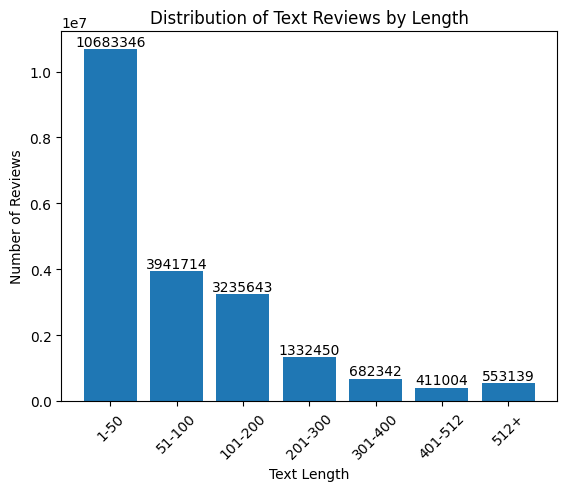

In [ ]:
df=pd.DataFrame()
for i in range(1,8):
  print(f" {i}  file of books")
  file_path=f"/content/drive/MyDrive/books_to_kindle_and_books_parquets/books/books_{i}.parquet"
  df_books=pl.read_parquet(file_path)
  df_books=df_books.to_pandas()
  df=pd.concat([df,df_books])


df['style'] = df['style'].astype(str)
print("info")
print(df.info())
print("")
print("describe")
print(df.describe().round(2))
print("")
print("head")
print(df.head())
print("")
print("shape")
print(df.shape)
print("")
reviews_count = df.groupby(['reviewerID', 'asin']).size().reset_index(name='number_of_reviews').sort_values(by='number_of_reviews', ascending=False)
print("aggregat by reviewerID and asin")
print(reviews_count)
print("")
print("total of more than one review for same asin for same reviewer")
print((reviews_count[reviews_count["number_of_reviews"] > 1])["number_of_reviews"].sum())
print("")
print("how many NAs")
print(df.apply(lambda col: col.isna().sum()))
print("")
print("duplicated rows")
print(df.duplicated().sum())
print("\n\n\n\n\n\n")

    #checking for books length
df = df.dropna(subset=['reviewText'])
    # Define the bins
bins = [0, 50, 100, 200, 300, 400, 512, float('inf')]
labels = ['1-50', '51-100', '101-200', '201-300', '301-400', '401-512', '512+']

    # Add a new column with the length of each text review
df['text_length'] = df['reviewText'].apply(lambda x: len(x.split()))

    # Bin the data
df['text_length_bins'] = pd.cut(df['text_length'], bins=bins, labels=labels, right=False)

    # Count the number of reviews in each bin
bin_counts = df['text_length_bins'].value_counts().sort_index()

    # Plot the bar graph
plt.bar(bin_counts.index, bin_counts.values)
plt.xlabel('Text Length')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Text Reviews by Length')
    # Annotate each bar with its count
for i, count in enumerate(bin_counts):
  plt.text(i, count, str(count), ha='center', va='bottom')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()